<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Обзор данных


In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from lightgbm import LGBMRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


# зафиксируем псевдослучайность 
rnd_state = 12345

In [2]:
# загрузим данные
# распознавание дат и формирование новых индексов
data = pd.read_csv('/datasets/taxi.csv',
                   index_col=[0],
                   parse_dates=[0])

In [3]:
# изучим файл
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
print(data.shape)

(26496, 1)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


>Чтобы проверить, в хронологическом ли порядке расположены даты и время, посмотрим атрибут индекса таблицы is_monotonic (англ. «монотонный»). Если порядок соблюдён, атрибут вернёт True, если нет — False.

In [7]:
data.index.is_monotonic

True

<AxesSubplot:xlabel='datetime'>

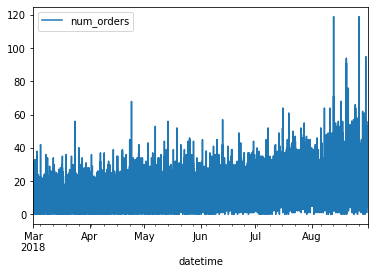

In [8]:
# построим график временного ряда
data.plot()

>**Ресемплирование.** По графику ни чего не понятно, поменяем интервал временного ряда, и выполним ресемплирование по одному часу.
Ресемплирование, или ресемплинг (англ. resample, «повторная выборка»), — это изменение интервала со значениями ряда.

<AxesSubplot:xlabel='datetime'>

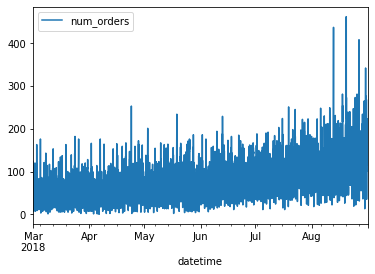

In [9]:
# 1H англ. hour, 1 час
data = data.resample('1H').sum()
data.plot()

<div style="border:solid green 2px; padding: 20px">

**Вывод**

Перед нами исторические данные компании «Чётенькое такси» о заказах такси в аэропортах. Данные находятся в файле /datasets/taxi.csv.
    
Рассмотрим столбцы таблицы:
    
- 'datetime' (англ. «дата-время») — значение даты и времени на временной оси. Переменная называется так же, как и тип данных datetime. В этой таблице интервал равен 10 минутам.    
- 'num_orders' (от англ. number of orders, «число заказов») - количество заказов такси.

Представлены данные с марта 2018 по август 2018 год. Дата и время расположены в хронологическом порядке. 
    
Выполнили ресемплирование данных по одному часу. Данные готовы к анализу.  
    
Отметим, что с июня наблюдается повышение количества заказов, пик приходится на август. Возможно, потому что август считается наиболее популярным месяцем для отпуска.
    
Продолжим анализ и обработку данных.    
        
</div>     

## Анализ

In [10]:
# проверим данные на наличие дубликатов
data.duplicated().sum()

4165

>Обнаружены дубликаты, но удалять их не будем - это скорее всего повторяющиеся даты, т.к. интревал у нас составляет 1 час. Если удалим, то останется по одному значению за день и мы потеряем практически все данные для анализа.

Чтобы во временном ряду снизить колебания, применим **скользящее среднее** — метод сглаживания временных рядов. Его суть заключается в поиске значений, которые меньше всего подвержены колебаниям, то есть средних арифметических.

<AxesSubplot:xlabel='datetime'>

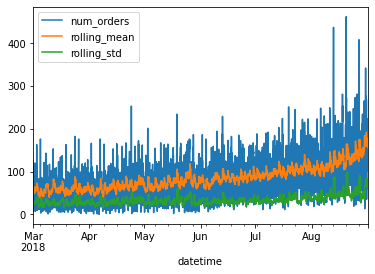

In [11]:
df = data.copy()
df['rolling_mean'] = df['num_orders'].rolling(20).mean()
df['rolling_std'] = df['num_orders'].rolling(20).std()
df.plot()

>Изначально выборка достаточно стационарна.

In [12]:
# проверим данные на пропуски
df.isna().sum()

num_orders       0
rolling_mean    19
rolling_std     19
dtype: int64

In [13]:
# удалим пропуски
df['rolling_mean'] = df['rolling_mean'].fillna(0)

# проверим удаление
data.isna().sum()

num_orders    0
dtype: int64

Чтобы лучше понимать временной ряд, посморим на **тренды и сезонность**. Функция seasonal_decompose() (англ. «разбить на части») раскладывает временной ряд на три составляющие: тренд, сезонность и остаток (англ. residuals). Это компонента, которая не объясняется трендом и сезонностью, это шум.

In [14]:
# разложим временной ряд на тренд и сезонную компоненту
decomposed = seasonal_decompose(data)

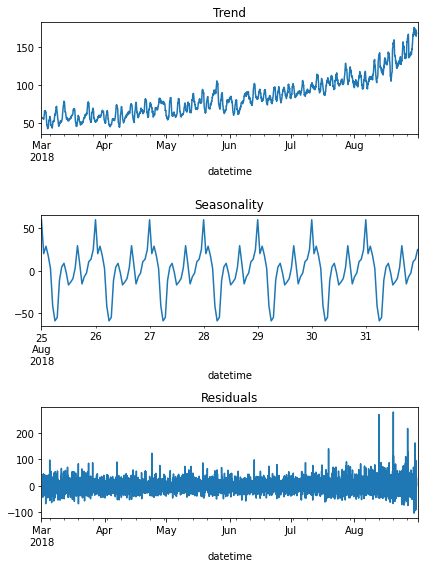

In [15]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.tail(24*7).plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

>Тренд связан с временем года: летом количество вызовов такси, по сравнению с весной - выше, пик приходится на август. А сезонность с периодом в одни сутки. Исследуем август дальше.

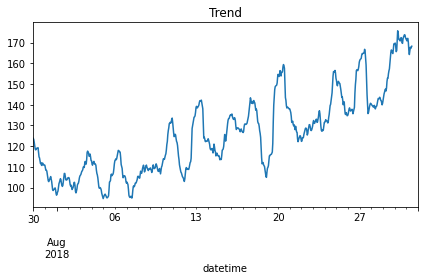

In [16]:
# тренд август
decomposed.trend['2018-07-30':'2018-08-31'].plot(ax=plt.gca()) 
plt.title('Trend')
plt.tight_layout()

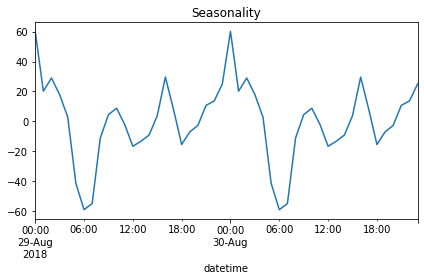

In [17]:
# сезон сутки
decomposed.seasonal['2018-08-29':'2018-08-30'].plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.tight_layout()

<div style="border:solid green 2px; padding: 20px">
    
**Вывод**

Вообще, чтобы сделать корректные прогнозы - необходимо больше данных, лучше всего за несколько лет. Нельзя увидеть закономерности, повторяющиеся каждое лето, если представили данные меньше года. 

Поэтому исходя из анализа **имеющихся данных** можно отметить суточную сезонность, восходящий тренд в августе. 
    
Наиболее пиковый месяц август, ночное время, точнее полночь.
    
</div>         

## Обучение

- Создадим признаки для горизонта прогнозирования
- Разделим исходные данные на выборки.
- Для обучения будем использовать 5 моделей: CatBoostRegressor, LGBMRegressor, LinearRegression, RandomForestRegressor, Lasso.

In [18]:
# cоздадим признаки для горизонта прогнозирования

def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [19]:
#make_features(data, 4, 4)
make_features(data, 4, 24)
data.head()

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,4,1,3,66.0,71.0,85.0,124.0,NaN


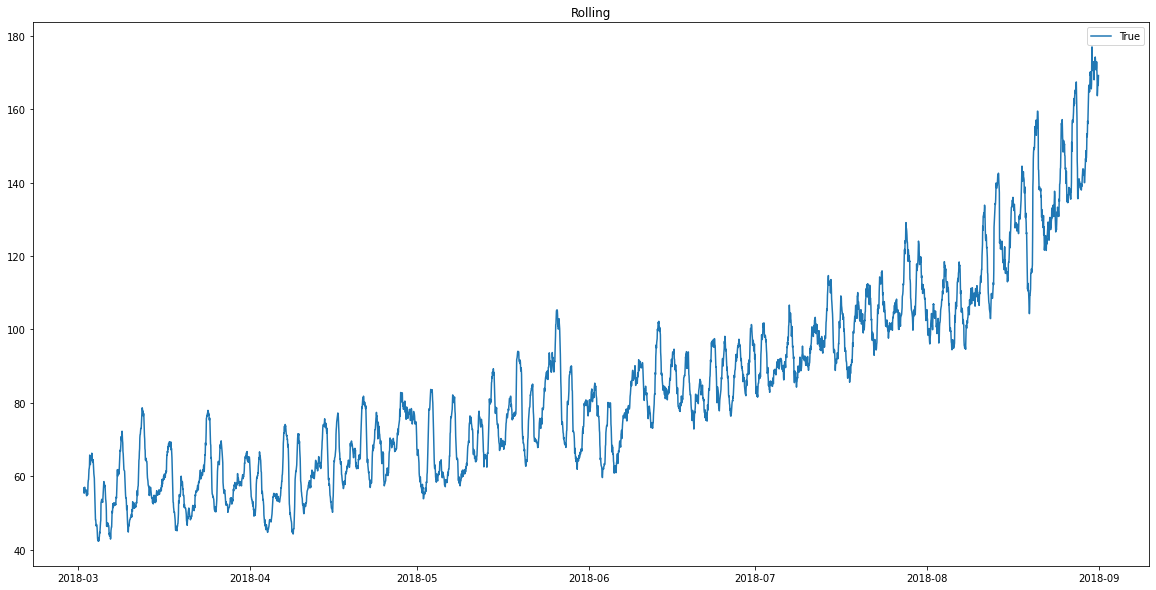

In [20]:
plt.figure(figsize=(20, 10))

plt.plot(data['rolling_mean'], label='True')

plt.title('Rolling')
plt.legend()
plt.show()

In [21]:
# разобъем данные на выборки
#train,test = train_test_split(data, shuffle = False, random_state = 42, test_size = 0.2)
#valid,test = train_test_split(test, shuffle = False, random_state = 42, test_size = 0.5)

train,test = train_test_split(data, shuffle = False, random_state = 42, test_size = 0.1)

# из обучающей выборки удалим строки с пропусками
train = train.dropna()

print('Размер выборок:')
print('Тренировочная:', train.shape)
#print('Валидационная:', valid.shape)
print('Тестовая:', test.shape)

Размер выборок:
Тренировочная: (3950, 9)
Тестовая: (442, 9)


In [22]:
# выделим признаки и целевой признак
(features_train,
#features_valid,
features_test) = (train.drop('num_orders',axis = 1),
                #  valid.drop('num_orders',axis = 1),
                  test.drop('num_orders',axis = 1))
(target_train,
#target_valid,
target_test) = (train['num_orders'],
              #  valid['num_orders'],
                test['num_orders'])

In [23]:
# LinearRegression

model = LinearRegression()
model.fit(features_train, target_train)
predict_lr = pd.DataFrame(model.predict(features_train))
rmse_lr = mean_squared_error(target_train, predict_lr) ** 0.5
print('RMSE LinearRegression:', rmse_lr)

RMSE LinearRegression: 30.679290329842217


In [24]:
# RandomForestRegressor

for i in range(1, 21):
    model_random = RandomForestRegressor(n_estimators=i, random_state=rnd_state)
    model_random.fit(features_train, target_train)
    
    predict_random = pd.DataFrame(model_random.predict(features_train))
    rmse_random = mean_squared_error(target_train, predict_random) ** 0.5
    print('n_estimators=', i, ':', rmse_random) 

n_estimators= 1 : 19.398486173482322
n_estimators= 2 : 14.832437511469433
n_estimators= 3 : 13.133352609808295
n_estimators= 4 : 12.069231331642825
n_estimators= 5 : 11.35409366871591
n_estimators= 6 : 10.902867724283405
n_estimators= 7 : 10.63770388729636
n_estimators= 8 : 10.463440345352932
n_estimators= 9 : 10.223817676508204
n_estimators= 10 : 10.100457565772686
n_estimators= 11 : 9.996091923866661
n_estimators= 12 : 9.826518145343217
n_estimators= 13 : 9.728054356854708
n_estimators= 14 : 9.67067189285261
n_estimators= 15 : 9.602494518849195
n_estimators= 16 : 9.579147728401084
n_estimators= 17 : 9.56693919756556
n_estimators= 18 : 9.5010079576476
n_estimators= 19 : 9.498868110940318
n_estimators= 20 : 9.453052952701698


In [25]:
# LGBMRegressor

from collections import defaultdict
d = defaultdict(list)

lgbm_model = LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=20, random_state=rnd_state)
lgbm_model.fit(features_train, target_train)
predict_lgbm = pd.DataFrame(lgbm_model.predict(features_train))
rmse_lgbm = mean_squared_error(target_train, predict_lgbm) ** 0.5

print("RMSE LGBMRegressor:", rmse_lgbm)

RMSE LGBMRegressor: 25.686274575669746


In [26]:
# CatBoostRegressor

cat_model = CatBoostRegressor(loss_function="RMSE", iterations=50, random_state=rnd_state)
cat_model.fit(features_train, target_train, verbose=10)

predict_cat = cat_model.predict(features_train)
rmse_cat = mean_squared_error(target_train, predict_cat) ** 0.5

print("RMSE CatBoostRegressor:", rmse_cat)

Learning rate set to 0.5
0:	learn: 30.2456249	total: 48.4ms	remaining: 2.37s
10:	learn: 22.6636085	total: 62.9ms	remaining: 223ms
20:	learn: 20.7761399	total: 77ms	remaining: 106ms
30:	learn: 19.5361381	total: 91.7ms	remaining: 56.2ms
40:	learn: 18.4188137	total: 108ms	remaining: 23.7ms
49:	learn: 17.5391708	total: 121ms	remaining: 0us
RMSE CatBoostRegressor: 17.539170802634384


In [27]:
# Lasso

lasso_model = linear_model.Lasso(alpha=0.1)
lasso_model.fit(features_train, target_train)

predict_lasso = lasso_model.predict(features_train)
rmse_lasso = mean_squared_error(target_train, predict_lasso) ** 0.5

print("RMSE Lasso:", rmse_lasso)

RMSE Lasso: 30.67932071511903


In [28]:
# выведем результат на экран

data_score = pd.Series({'LinearRegression': rmse_lr,
                           'LightGBM': rmse_lgbm,
                           'RandomForest': rmse_random,
                           'Lasso': rmse_lasso,
                           'CatBoost': rmse_cat}) 

data_score


LinearRegression    30.679290
LightGBM            25.686275
RandomForest         9.453053
Lasso               30.679321
CatBoost            17.539171
dtype: float64

>
>- Oбучены 5 моделей: CatBoostRegressor, LGBMRegressor, LinearRegression, RandomForestRegressor, Lasso.
>- Подготовка к тестированию завершена.
>- Mодель "Случайного леса" показала наименьший результат. Далее проведем тестирование.

## Тестирование

In [29]:
# RandomForestRegressor

model_random = RandomForestRegressor(n_estimators=20, random_state=rnd_state)
model_random.fit(features_train, target_train)
    
predict_random = pd.DataFrame(model_random.predict(features_test))
rmse_random = mean_squared_error(target_test, predict_random) ** 0.5
print(rmse_random) 

46.77740515980084


In [30]:
# CatBoost

cat_model = CatBoostRegressor(loss_function="RMSE", iterations=50, random_state=rnd_state)
cat_model.fit(features_train, target_train, verbose=10)

predict_cat = cat_model.predict(features_test)
rmse_cat = mean_squared_error(target_test, predict_cat) ** 0.5

print("RMSE CatBoostRegressor:", rmse_cat)

Learning rate set to 0.5
0:	learn: 30.2456249	total: 1.71ms	remaining: 84ms
10:	learn: 22.6636085	total: 16.4ms	remaining: 58.3ms
20:	learn: 20.7761399	total: 30.5ms	remaining: 42.1ms
30:	learn: 19.5361381	total: 45ms	remaining: 27.6ms
40:	learn: 18.4188137	total: 59.9ms	remaining: 13.2ms
49:	learn: 17.5391708	total: 72.9ms	remaining: 0us
RMSE CatBoostRegressor: 45.667149595829784


In [31]:
# Lasso

lasso_model = linear_model.Lasso(alpha=0.1)
lasso_model.fit(features_train, target_train)

predict_lasso = lasso_model.predict(features_test)
rmse_lasso = mean_squared_error(target_test, predict_lasso) ** 0.5

print("RMSE Lasso:", rmse_lasso)

RMSE Lasso: 50.328462106192895


In [32]:
# LGBMRegressor

from collections import defaultdict
d = defaultdict(list)

lgbm_model = LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=20, random_state=rnd_state)
lgbm_model.fit(features_train, target_train)
predict_lgbm = pd.DataFrame(lgbm_model.predict(features_test))
rmse_lgbm = mean_squared_error(target_test, predict_lgbm) ** 0.5

print("RMSE LGBMRegressor:", rmse_lgbm)

RMSE LGBMRegressor: 61.091677290477776


In [33]:
# LinearRegression

model = LinearRegression()
model.fit(features_train, target_train)
predict_lr = model.predict(features_test)
rmse_lr = mean_squared_error(target_test, predict_lr) ** 0.5
print('RMSE LinearRegression:', rmse_lr)

RMSE LinearRegression: 50.32703808053819


<div style="border:solid green 2px; padding: 20px">
    
**ВЫВОДЫ**

- Данные ресемплированы по 1 часу
- Проведена генерация признаков
- Были исследованы 5 моделей регрессии
- Наиболее подходящая модель - Модель "Случайного леса"
- Достигнуто значение метрики RMSE на тестовой выборке - не более 48.    
    
</div>             

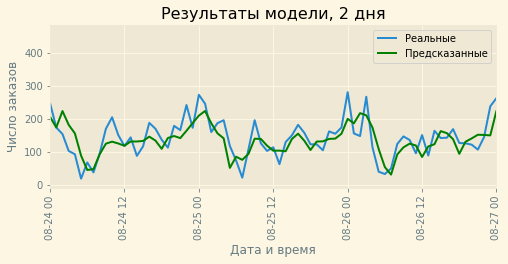